In [5]:
import pandas as pd
from tensorflow.keras.layers import Input, Embedding, Concatenate, Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.metrics import RootMeanSquaredError, MeanAbsoluteError
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

In [6]:
data = pd.read_csv("Final_Data_ratings 1.csv")

In [34]:
data.columns

Index(['userid', 'placeid', 'lng', 'lat', 'place_photos_count',
       'place_checkins_count', 'place_radius_meters', 'user_pins_count',
       'user_friends_count', 'user_checkin_num', 'user_trips_count',
       'place_name', 'ratings'],
      dtype='object')

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


   3/7122 [..............................] - ETA: 3:13 - loss: 4.0487 - root_mean_squared_error: 2.0121 - mean_absolute_error: 1.0551

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


   3/7122 [..............................] - ETA: 3:12 - loss: 0.8381 - root_mean_squared_error: 0.9155 - mean_absolute_error: 0.5778

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


   3/7122 [..............................] - ETA: 3:10 - loss: 1.7422 - root_mean_squared_error: 1.3199 - mean_absolute_error: 0.6116

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


   3/7122 [..............................] - ETA: 3:17 - loss: 2.3482 - root_mean_squared_error: 1.5324 - mean_absolute_error: 0.8178

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


7122/7122 [==============================] - 202s 28ms/step - loss: 1.9979 - root_mean_squared_error: 1.4135 - mean_absolute_error: 0.6895 - val_loss: 2.5543 - val_root_mean_squared_error: 1.5982 - val_mean_absolute_error: 0.7268


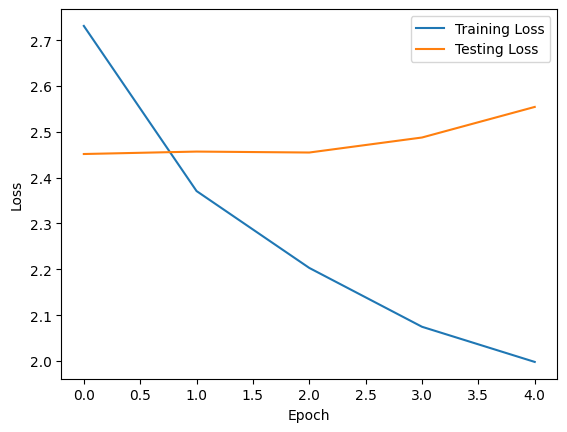

In [7]:
# Define embedding dimensions
embedding_dim = 10

# User input
user_input = Input(shape=(1,), name='user_input')
user_embedding = Embedding(input_dim=data['userid'].max()+1, output_dim=embedding_dim)(user_input)
user_embedding = tf.keras.layers.Flatten()(user_embedding)
user_features_input = Input(shape=(3,), name='user_features_input')

# Item input
item_input = Input(shape=(1,), name='item_input')
item_embedding = Embedding(input_dim=data['placeid'].max()+1, output_dim=embedding_dim)(item_input)
item_embedding = tf.keras.layers.Flatten()(item_embedding)
item_features_input = Input(shape=(4,), name='item_features_input')

# Concatenate user and item embeddings with user and item features
user_concat = Concatenate()([user_embedding, user_features_input])
item_concat = Concatenate()([item_embedding, item_features_input])

# Merge towers with a dense layer
merged = Concatenate()([user_concat, item_concat])
merged = Dropout(0.5)(merged)
merged = Dense(64, activation='relu')(merged)  # Additional dense layer
merged = Dropout(0.3)(merged)
merged = Dense(32, activation='relu')(merged)

# Output layer
output = 10*Dense(1, activation='sigmoid')(merged)


# Build model
model = Model(inputs=[user_input, user_features_input, item_input, item_features_input], outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=[RootMeanSquaredError(), MeanAbsoluteError()])

# Prepare data
user_features = data[['user_pins_count', 'user_checkin_num', 'user_trips_count']].values
item_features = data[['lat','lng','place_photos_count', 'place_checkins_count']].values
ratings = data['ratings'].values

# Standardize user and item features
scaler_user = StandardScaler()
scaler_item = StandardScaler()

user_features_scaled = scaler_user.fit_transform(user_features)
item_features_scaled = scaler_item.fit_transform(item_features)

# Train-test split with random_state=42
train_df, test_df = train_test_split(data, test_size=0.2, random_state=42)
# Lists to store training and validation loss
train_loss_history = []
val_loss_history = []

# Train the model and store loss history
for epoch in range(5):
    history = model.fit(
        [train_df['userid'], user_features_scaled[train_df.index], train_df['placeid'], item_features_scaled[train_df.index]],
        ratings[train_df.index],
        epochs=1,
        batch_size=16,
        validation_data=(
            [test_df['userid'], scaler_user.transform(test_df[['user_pins_count', 'user_checkin_num', 'user_trips_count']]),
             test_df['placeid'], scaler_item.transform(test_df[['lat','lng','place_photos_count', 'place_checkins_count']])],
            test_df['ratings']
        )
    )

    # Store training and validation loss for each epoch
    train_loss_history.extend(history.history['loss'])
    val_loss_history.extend(history.history['val_loss'])

# Plot training and validation loss
plt.plot(train_loss_history, label='Training Loss')
plt.plot(val_loss_history, label='Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [8]:
# Evaluate the model on the testing set
test_metrics = model.evaluate(
    [test_df['userid'], scaler_user.transform(test_df[['user_pins_count', 'user_checkin_num', 'user_trips_count']]),
     test_df['placeid'], scaler_item.transform(test_df[['lat','lng','place_photos_count', 'place_checkins_count']])],
    test_df['ratings'],
    batch_size=16
)

# Display evaluation metrics
print("Testing RMSE:", test_metrics[1])
print("Testing MAE:", test_metrics[2])

  30/1781 [..............................] - ETA: 6s - loss: 2.9187 - root_mean_squared_error: 1.7084 - mean_absolute_error: 0.7502

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


1781/1781 [==============================] - 7s 4ms/step - loss: 2.5543 - root_mean_squared_error: 1.5982 - mean_absolute_error: 0.7268
Testing RMSE: 1.5982083082199097
Testing MAE: 0.7268167734146118


In [23]:
from collections import defaultdict

def precision_recall_at_k(model, test_df, k=10, threshold=3.5):
    """
    Return precision and recall at k metrics for each user using the provided model.
    """
    test_predictions = model.predict(
        [test_df['userid'], scaler_user.transform(test_df[['user_pins_count', 'user_checkin_num', 'user_trips_count']]),
         test_df['placeid'], scaler_item.transform(test_df[['lat','lng','place_photos_count', 'place_checkins_count']])],
        batch_size=16
    )

    # Set a threshold for relevance
    true_labels = (test_df['ratings'] >= threshold).astype(int)

    # Create a dictionary to store estimated and true ratings for each user
    user_est_true = defaultdict(list)
    i=0
    for _, row in test_df.iterrows():
        uid = row['userid']
        est = test_predictions[i][0]
        true_r = row['ratings']
        user_est_true[uid].append((est, true_r))
        i += 1

    precisions = dict()
    recalls = dict()

    for uid, user_ratings in user_est_true.items():
        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold)) for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. We here set it to 0.
        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. We here set it to 0.
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    return precisions, recalls

# Example usage:
precisions, recalls = precision_recall_at_k(model, test_df, k=10, threshold=0.0001)

# Display the results
precision = np.mean(list(precisions.values()))
recall = np.mean(list(recalls.values()))
print("Precision@10 for Two tower model:", precision)
print("Recall@10 for Two tower model:", recall)
print("F1 score@10 for Two tower model:", 2*precision*recall/(precision+recall))

  41/1781 [..............................] - ETA: 4s

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


1781/1781 [==============================] - 4s 2ms/step
Precision@10: 0.12937761920942348
Recall@10: 0.41194409905419077
F1 score@10: 0.19691191018147078


In [10]:
test_predictions = model.predict(
        [test_df['userid'], scaler_user.transform(test_df[['user_pins_count', 'user_checkin_num', 'user_trips_count']]),
         test_df['placeid'], scaler_item.transform(test_df[['lat','lng','place_photos_count', 'place_checkins_count']])],
        batch_size=16
    )

  29/1781 [..............................] - ETA: 6s

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


1781/1781 [==============================] - 8s 4ms/step


In [12]:
len(test_predictions)

28488

In [13]:
len(test_df)

28488

  19/1781 [..............................] - ETA: 5s 

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


  57/1781 [..............................] - ETA: 3s

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


  53/1781 [..............................] - ETA: 3s

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


  52/1781 [..............................] - ETA: 3s

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


  37/1781 [..............................] - ETA: 4s

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


  39/1781 [..............................] - ETA: 4s

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


1781/1781 [==============================] - 4s 2ms/step


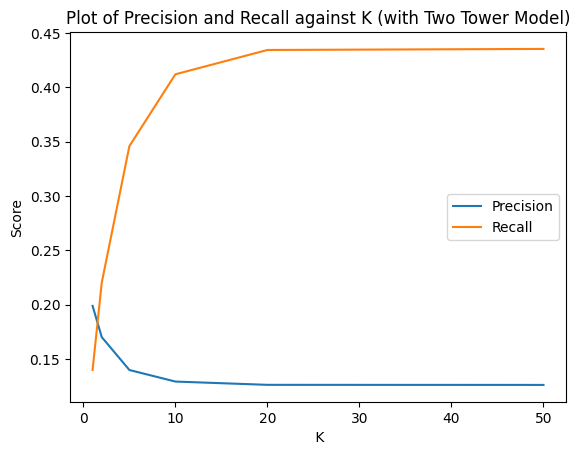

In [21]:
# Define a range of k values
k_values = [1, 2, 5, 10, 20, 50]

# Initialize lists to store precision and recall values
precisions = []
recalls = []

# Calculate precision and recall at different values of k
for k in k_values:
    precisions_k, recalls_k = precision_recall_at_k(model, test_df, k=k, threshold=0.0001)
    avg_precision_k = sum(prec for prec in precisions_k.values()) / len(precisions_k)
    avg_recall_k = sum(rec for rec in recalls_k.values()) / len(recalls_k)
    precisions.append(avg_precision_k)
    recalls.append(avg_recall_k)

# Plot precision and recall at different values of k
plt.plot(k_values, precisions, label='Precision')
plt.plot(k_values, recalls, label='Recall')
plt.xlabel(' K')
plt.ylabel('Score')
plt.title("Plot of Precision and Recall against K (with Two Tower Model)")
plt.legend()
plt.show()

In [31]:
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 user_input (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 item_input (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 embedding_1 (Embedding)     (None, 1, 10)                2681173   ['user_input[0][0]']          
                                                          0                                       
                                                                                                  
 embedding_2 (Embedding)     (None, 1, 10)                7582723   ['item_input[0][0]']      

In [25]:
import networkx as nx


In [27]:
# Filter predictions for 5 users
user_ids_to_visualize = data['userid'].unique()[:5]

# Get predictions for the test set
test_predictions = model.predict(
    [test_df['userid'], scaler_user.transform(test_df[['user_pins_count', 'user_checkin_num', 'user_trips_count']]),
     test_df['placeid'], scaler_item.transform(test_df[['lat','lng','place_photos_count', 'place_checkins_count']])],
    batch_size=16
)

# Set a threshold for relevance
threshold = 7  # Adjust this threshold based on your ratings scale

# Convert predicted ratings to binary relevance using the threshold
binary_predictions = (test_predictions >= threshold).astype(int)

# Create a graph
G = nx.Graph()

# Add nodes for users and recommended places
for user_id in user_ids_to_visualize:
    G.add_node(user_id, label=f'User {user_id}', color='blue', size=20)
    user_predictions = binary_predictions[test_df['userid'] == user_id]
    top_recommendations = np.argsort(user_predictions)[::-1][:4]
    print(place_id)
    for place_id in top_recommendations:
        place_name = data.loc[data['placeid'] == place_id, 'place_name'].values[0]
        G.add_node(place_id, label=f'{place_name}\nPlace ID: {place_id}', color='green', size=10)
        G.add_edge(user_id, place_id)

# Add nodes for places already visited by the same users
visited_places = data[data['userid'].isin(user_ids_to_visualize)].groupby('userid').apply(lambda x: x.sample(n=2)).reset_index(drop=True)
for _, row in visited_places.iterrows():
    user_id = row['userid']
    place_id = row['placeid']
    place_name = row['place_name']
    G.add_node(place_id, label=f'{place_name}\nPlace ID: {place_id}', color='red', size=15)
    G.add_edge(user_id, place_id)

# Set node colors based on 'color' attribute
node_colors = [G.nodes[node]['color'] for node in G.nodes]

# Set node sizes based on 'size' attribute
node_sizes = [G.nodes[node]['size'] * 100 for node in G.nodes]

# Set node labels based on 'label' attribute
node_labels = {node: G.nodes[node]['label'] for node in G.nodes}

# Create a layout for our nodes (using Kamada-Kawai layout in this example)
pos = nx.spring_layout(G, k=0.6)
plt.figure(figsize=(15, 15))

# Draw the network with node labels
nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=8, font_color='black', font_weight='bold')
nx.draw_networkx_edges(G, pos, edge_color='gray', alpha=0.5)  # Default edge color and alpha
nx.draw(G, pos, with_labels=False, node_color=node_colors, node_size=node_sizes, font_size=8, font_color='black', font_weight='bold')

# Create a legend
legend_labels = {'Recommended Places': 'green', 'Visited Places': 'red', 'Users': 'blue'}
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label=label, markerfacecolor=color, markersize=10) for label, color in legend_labels.items()]

# Display the legend
plt.legend(handles=legend_elements, loc='upper left')

# Show the plot
plt.title("Recommendations with Collaborative Filtering Model")
plt.show()

   1/1781 [..............................] - ETA: 1:42

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


1781/1781 [==============================] - 6s 3ms/step
[0]


ValueError: ignored

In [37]:
all_predictions = model.predict([
    np.array(test_df['userid']),
    scaler_user.transform(test_df[['user_pins_count', 'user_checkin_num', 'user_trips_count']]),
    np.array(test_df['placeid']),
    scaler_item.transform(test_df[['lat', 'lng', 'place_photos_count', 'place_checkins_count']])
]).flatten()

# Add the predictions to the DataFrame
test_df['predictions'] = all_predictions

# Iterate over each user and get top 5 recommendations
user_ids = test_df['userid'].unique()[:5]

for user_id in user_ids:
    # Get the top 5 recommendations for the current user
    user_recommendations = test_df[test_df['userid'] == user_id].nlargest(5, 'predictions')

    # Display user-specific recommendations
    print(f"\nTop 5 Recommendations for User {user_id}:")
    for _, row in user_recommendations.iterrows():
        place_id = row['placeid']
        prediction = row['predictions']

        # Get place name from the original data
        place_name = data.loc[data['placeid'] == place_id, 'place_name'].values[0]

        print(f"Place ID: {place_id}, Place Name: {place_name}")

 12/891 [..............................] - ETA: 4s 

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


891/891 [==============================] - 3s 3ms/step

Top 5 Recommendations for User 9458:
Place ID: 7224507, Place Name: Bona Fides
Place ID: 292657, Place Name: Salon De Ning
Place ID: 27836, Place Name: The Chelsea Market
Place ID: 284775, Place Name: Clinton St. Baking Company

Top 5 Recommendations for User 74284:
Place ID: 1391695, Place Name: Totale Pizza
Place ID: 579505, Place Name: Robongi
Place ID: 11720, Place Name: Yankee Stadium
Place ID: 167378, Place Name: Tapéo 29
Place ID: 59533, Place Name: Katsu-Hama

Top 5 Recommendations for User 185554:
Place ID: 12505, Place Name: LGA LaGuardia Airport
Place ID: 11738, Place Name: Battery Park
Place ID: 11978, Place Name: Statue of Liberty Pier
Place ID: 11975, Place Name: Statue of Liberty

Top 5 Recommendations for User 309599:
Place ID: 177792, Place Name: Midtown Tunnel
Place ID: 286318, Place Name: Jeffrey New York
Place ID: 194358, Place Name: Pastis
Place ID: 611928, Place Name: Starbucks
Place ID: 748402, Place Name: A

In [38]:
model.save("tow_tower.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
